# Computer Vision Mini Project
#### - Name: Jasser Abdelfattah
#### - UH ID: 21033101

## Loading CIFAR-10 and Data Preprocessing

In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split

In [2]:
# Preprocessing
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomCrop(32, padding=4), # randomly crop image
    transforms.ToTensor(), # convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalize
])

In [3]:
# Load CIFAR-10 Dataset
train_dataset = datasets.CIFAR10(root='./CIFAR10_data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./CIFAR10_data', train=False, download=True, transform=transform)

# Split training dataset into training and validation subsets
train_size = int(0.8 * len(train_dataset)) # 80% training, 20% validation
val_size = len(train_dataset) - train_size 
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size]) 

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [01:00<00:00, 2.80MB/s]   


Extracting ./CIFAR10_data\cifar-10-python.tar.gz to ./CIFAR10_data
Files already downloaded and verified


In [4]:
classes = (
    "plane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
    )

## Load pre-trained EfficientNet-b0 Model
#### - https://paperswithcode.com/method/efficientnet
#### - https://arxiv.org/pdf/1905.11946v5

In [5]:
import torch.nn as nn
from torchvision.models import EfficientNet_B0_Weights, efficientnet_b0

In [6]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device.type       

'cuda'

In [7]:
# Load EfficientNet Model and Modify for CIFAR-10
model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10)
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## Training EfficientNet-b0 Model

In [8]:
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

In [9]:
# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning Rate Scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# Mixed Precision Training setup
scaler = torch.amp.GradScaler()

In [10]:
# Initialize lists for tracking loss and accuracy
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training Loop with Early Stopping
best_val_loss = float('inf')
patience = 5
counter = 0

for epoch in range(50):  # Maximum number of epochs
    model.train()  # Set the model to training mode
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Clear the gradients

        with torch.amp.autocast(device_type='cuda'):  # Mixed precision training
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()  # Backpropagation
        scaler.step(optimizer)  # Update the weights
        scaler.update()  # Update the scaler

        train_loss += loss.item()
        _, predicted = outputs.max(1)  # Get the predicted class
        correct_train += predicted.eq(labels).sum().item()  # Count correct predictions
        total_train += labels.size(0)  # Count total samples

    train_accuracy = 100 * correct_train / total_train  # Calculate training accuracy
    train_losses.append(train_loss / len(train_loader))  # Average training loss
    train_accuracies.append(train_accuracy)  # Append training accuracy

    scheduler.step()  # Step the learning rate scheduler

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)  # Get the predicted class
            correct_val += predicted.eq(labels).sum().item()  # Count correct predictions
            total_val += labels.size(0)  # Count total samples

    val_accuracy = 100 * correct_val / total_val  # Calculate validation accuracy
    val_losses.append(val_loss / len(val_loader))  # Average validation loss
    val_accuracies.append(val_accuracy)  # Append validation accuracy

    # Print epoch statistics
    print(f"Epoch [{epoch+1}], Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'Models/efficientnet-b0_cifar10_pretrained.pth')  # Save the best model
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

Epoch [1], Train Loss: 1.2093, Train Accuracy: 58.13%, Val Loss: 0.8033, Val Accuracy: 71.95%
Epoch [2], Train Loss: 0.8154, Train Accuracy: 72.39%, Val Loss: 0.6588, Val Accuracy: 77.38%
Epoch [3], Train Loss: 0.7056, Train Accuracy: 75.94%, Val Loss: 0.6177, Val Accuracy: 78.99%
Epoch [4], Train Loss: 0.6360, Train Accuracy: 78.51%, Val Loss: 0.5729, Val Accuracy: 80.67%
Epoch [5], Train Loss: 0.5871, Train Accuracy: 79.95%, Val Loss: 0.5311, Val Accuracy: 81.56%
Epoch [6], Train Loss: 0.5525, Train Accuracy: 81.27%, Val Loss: 0.5282, Val Accuracy: 81.67%
Epoch [7], Train Loss: 0.5193, Train Accuracy: 82.40%, Val Loss: 0.5114, Val Accuracy: 82.46%
Epoch [8], Train Loss: 0.4960, Train Accuracy: 83.22%, Val Loss: 0.4980, Val Accuracy: 83.20%
Epoch [9], Train Loss: 0.4728, Train Accuracy: 83.86%, Val Loss: 0.4936, Val Accuracy: 83.26%
Epoch [10], Train Loss: 0.4585, Train Accuracy: 84.56%, Val Loss: 0.4725, Val Accuracy: 83.93%
Epoch [11], Train Loss: 0.3457, Train Accuracy: 88.16%, Val

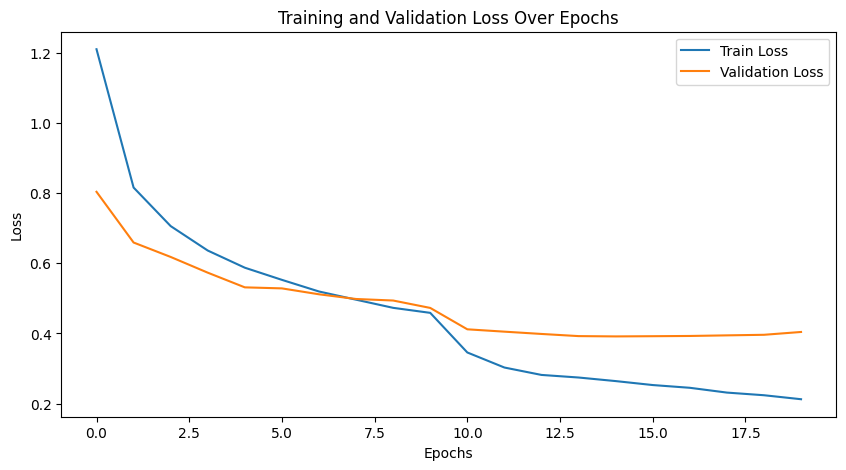

In [11]:
# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

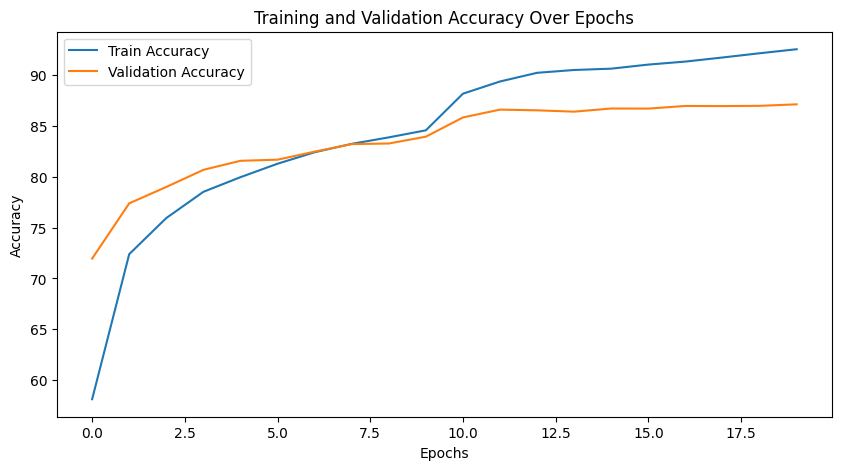

In [12]:
# Plot training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

# Evaluating EfficientNet-b0 Model

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [14]:
# Initialize variables to track the overall correct predictions and total samples
correct = 0
total = 0

# Initialize lists to track the correct predictions and total samples for each class
class_correct = list(0.0 for i in range(10))
class_total = list(0.0 for i in range(10))

# Disable gradient calculation for evaluation
with torch.no_grad():
    for data in test_loader:
        images, labels = data  # Get the images and labels from the test loader
        images, labels = images.to(device), labels.to(device)  # Move images and labels to the device
        outputs = model(images)  # Forward pass: compute the outputs of the network
        _, predicted = torch.max(outputs, 1)  # Get the predicted class with the highest score
        c = (predicted == labels).squeeze()  # Compare predictions with the true labels

        # Update the correct predictions and total samples for each class
        for i in range(len(labels)):
            label = labels[i]  # Get the true label
            class_correct[label] += c[i].item()  # Increment the correct count for the class
            class_total[label] += 1  # Increment the total count for the class

# Print the accuracy for each class
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Accuracy of %5s : %2d %%" % (classes[i], 100 * class_correct[i] / class_total[i]))

# Calculate and print the overall accuracy of the network
overall_accuracy = 100.0 * sum(class_correct) / sum(class_total)
print("Accuracy of the network on the 10000 test images: %d %%" % overall_accuracy)

Accuracy of plane : 89 %
Accuracy of automobile : 92 %
Accuracy of  bird : 82 %
Accuracy of   cat : 73 %
Accuracy of  deer : 86 %
Accuracy of   dog : 78 %
Accuracy of  frog : 92 %
Accuracy of horse : 89 %
Accuracy of  ship : 92 %
Accuracy of truck : 89 %
Accuracy of the network on the 10000 test images: 86 %


In [15]:
# Extract true labels and predicted labels
y_true = []
y_pred = []

# Disable gradient calculation for evaluation
with torch.no_grad():
	for data in test_loader:
		images, labels = data  # Get the images and labels from the test loader
		images, labels = images.to(device), labels.to(device)  # Move images and labels to the device
		outputs = model(images)  # Forward pass: compute the outputs of the network
		_, predicted = torch.max(outputs, 1)  # Get the predicted class with the highest score
		y_true.extend(labels.cpu().numpy())  # Append true labels to the list
		y_pred.extend(predicted.cpu().numpy())  # Append predicted labels to the list

In [16]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))


Classification Report:
              precision    recall  f1-score   support

       plane       0.87      0.89      0.88      1000
  automobile       0.93      0.93      0.93      1000
        bird       0.84      0.83      0.84      1000
         cat       0.75      0.72      0.74      1000
        deer       0.85      0.87      0.86      1000
         dog       0.80      0.78      0.79      1000
        frog       0.89      0.93      0.91      1000
       horse       0.89      0.90      0.90      1000
        ship       0.93      0.93      0.93      1000
       truck       0.91      0.90      0.91      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



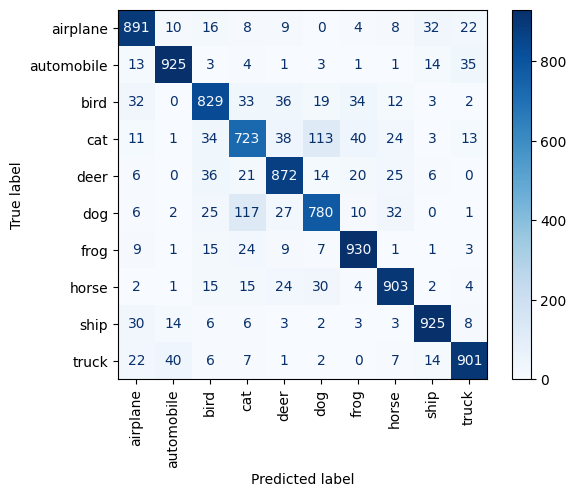

In [17]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.show()

## Prediction on Unseen Images

In [18]:
import os
from PIL import Image

In [19]:
def predict_images_in_folder(model, folder_path, classes, device):
    # Define the image transformations (resize, normalize, etc.)
    transform = transforms.Compose([
        transforms.Resize((32, 32)),  # Resize the image to the input size expected by the model
        transforms.ToTensor(),  # Convert the image to a tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image
    ])

    # Set the model to evaluation mode
    model.eval()

    # Iterate through all images in the folder
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        image = Image.open(image_path)
        image = transform(image).unsqueeze(0)  # Apply transformations and add batch dimension
        image = image.to(device)  # Move the image to the device (GPU or CPU)

        # Disable gradient calculation
        with torch.no_grad():
            outputs = model(image)  # Forward pass: compute the outputs of the network
            _, predicted = torch.max(outputs, 1)  # Get the predicted class with the highest score

        predicted_class = classes[predicted.item()]  # Get the predicted class label

        # Display the image along with the predicted label and file name
        image = image.cpu().squeeze().permute(1, 2, 0).numpy()  # Move image back to CPU and convert to numpy array
        image = image * 0.5 + 0.5  # Unnormalize the image
        plt.imshow(image)
        plt.title(f"Predicted: {predicted_class}\nImage Label: {image_name}")
        plt.show()

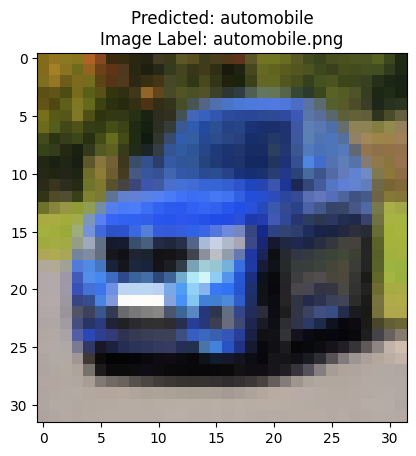

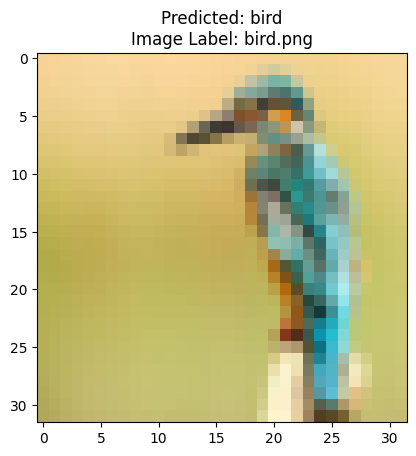

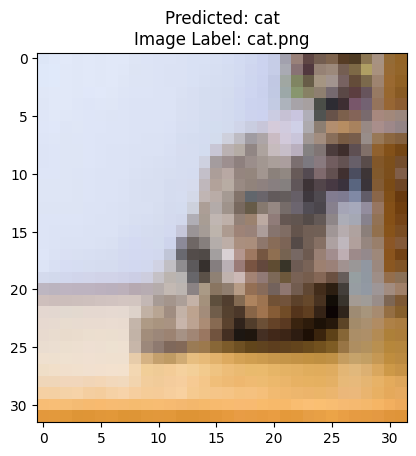

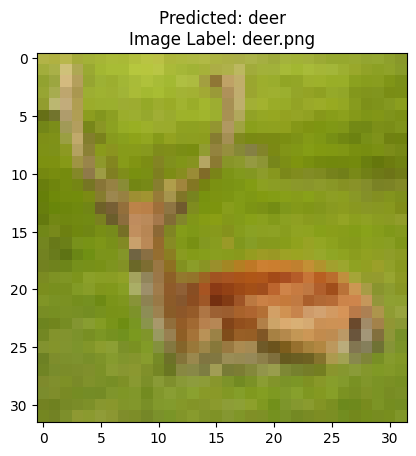

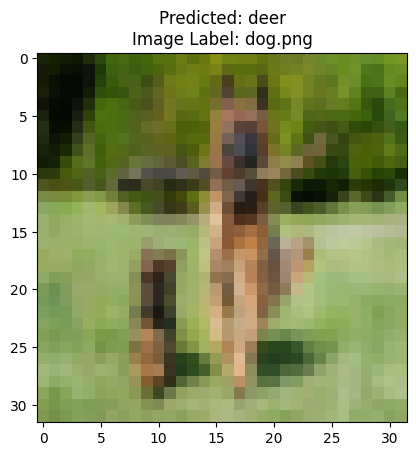

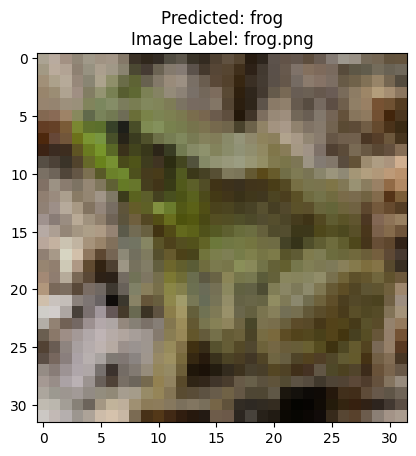

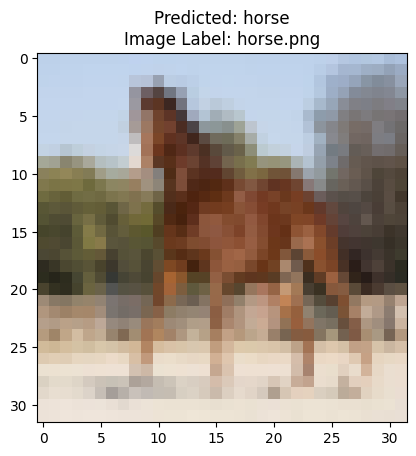

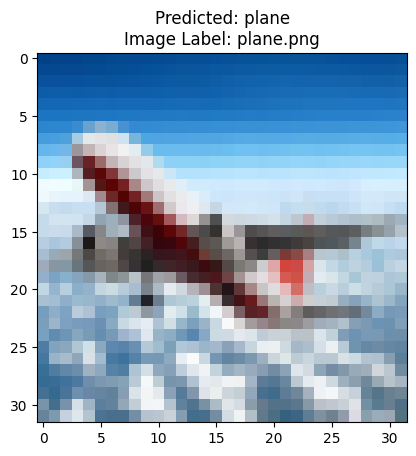

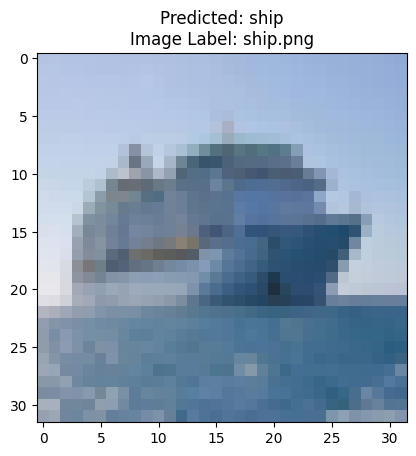

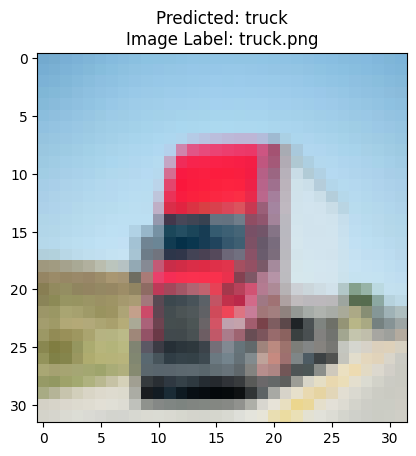

In [20]:
folder_path = "UnseenImages"  
predict_images_in_folder(model, folder_path, classes, device)

## Model Summary

In [21]:
from torchinfo import summary

In [22]:
# Load the state dict 
state_dict = torch.load('Models/efficientnet-b0_cifar10_pretrained.pth', weights_only=True)
model.load_state_dict(state_dict)
model.to(device)

# Print the model summary
summary(model, input_size=(64, 3, 32, 32))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [64, 10]                  --
├─Sequential: 1-1                                       [64, 1280, 1, 1]          --
│    └─Conv2dNormActivation: 2-1                        [64, 32, 16, 16]          --
│    │    └─Conv2d: 3-1                                 [64, 32, 16, 16]          864
│    │    └─BatchNorm2d: 3-2                            [64, 32, 16, 16]          64
│    │    └─SiLU: 3-3                                   [64, 32, 16, 16]          --
│    └─Sequential: 2-2                                  [64, 16, 16, 16]          --
│    │    └─MBConv: 3-4                                 [64, 16, 16, 16]          1,448
│    └─Sequential: 2-3                                  [64, 24, 8, 8]            --
│    │    └─MBConv: 3-5                                 [64, 24, 8, 8]            6,004
│    │    └─MBConv: 3-6                              